In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import itertools
import networkx as nx

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from numba import jit

In [4]:
import met_brewer

In [5]:
import importlib
import evotsc
import evotsc_lib
import evotsc_plot
importlib.reload(evotsc)
importlib.reload(evotsc_lib)
importlib.reload(evotsc_plot)

<module 'evotsc_plot' from '/Users/theotime/Work/Code/papers/phd-evotsc/evotsc_plot.py'>

In [6]:
label_fontsize=20
tick_fontsize=15
legend_fontsize=15
dpi=300

In [7]:
exp_paths = [pathlib.Path('/Users/theotime/Desktop/evotsc/phd/param-explor/main/'),  # 1e-2
             pathlib.Path('/Users/theotime/Desktop/evotsc/phd/param-explor/sigma-1e-3/'),
             pathlib.Path('/Users/theotime/Desktop/evotsc/phd/param-explor/sigma-1e-4/')]
exp_names = ['$10^{-2}$ (main)', '$10^{-3}$', '$10^{-4}$']
gen = 250_000
gene_types = ['AB', 'A', 'B'] # Name of each gene type
gene_type_color = ['tab:blue', 'tab:red', 'tab:green'] #AB, A, B
orient_name = ['leading', 'lagging'] # Name of each gene orientation
rel_orients = ['conv', 'div', 'downstr', 'upstr'] # In alphabetical order
envs = ['A', 'B'] # Environment names

In [8]:
rng = np.random.default_rng(seed=123456)

In [9]:
exp_rep_dirs = [sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
                for exp_path in exp_paths]

exp_params = [evotsc_lib.read_params(rep_dirs[0]) for rep_dirs in exp_rep_dirs]

In [10]:
for i_rep_dir, rep_dir in enumerate(exp_rep_dirs):
    print(f'{exp_names[i_rep_dir]}: {len(rep_dir)} reps')

$10^{-2}$ (main): 30 reps
$10^{-3}$: 15 reps
$10^{-4}$: 15 reps


In [11]:
for i_param in range(len(exp_params)):
    exp_params[i_param]['m'] = 2.5 # Temporary fix because the parameter wasn't saved

In [12]:
genes_per_type = exp_params[0]["nb_genes"] / len(gene_types)

# Make random individuals (reused throughout)

In [13]:
def make_random_indivs(nb_indiv, params):
    
    mutation = evotsc.Mutation(inversion_poisson_lam=params['inversion_poisson_lam'])
    
    rand_indivs = []
    
    
    for rep in range(nb_indiv):
        indiv = evotsc_lib.make_random_indiv(intergene=int(params['intergene']),
                                             gene_length=int(params['gene_length']),
                                             nb_genes=int(params['nb_genes']),
                                             default_basal_expression=params['default_basal_expression'],
                                             interaction_dist=params['interaction_dist'],
                                             interaction_coef=params['interaction_coef'],
                                             sigma_basal=params['sigma_basal'],
                                             sigma_opt=params['sigma_opt'],
                                             epsilon=params['epsilon'],
                                             m=params['m'],
                                             selection_coef=params['selection_coef'],
                                             mutation=mutation,
                                             rng=rng,
                                             nb_mutations=100)
        
        indiv.inter_matrix = indiv.compute_inter_matrix()

        rand_indivs.append(indiv)
        
    return rand_indivs

# Evolutionary stats

In [14]:
def get_stats(exp_name, gen):
    
    exp_name = pathlib.Path(exp_name)
        
    rep_dirs = sorted([d for d in exp_name.iterdir() if (d.is_dir() and d.name.startswith("rep"))])
    
    res = pd.DataFrame()
    
    for i_rep, rep_dir in enumerate(rep_dirs):
        
        res_dir = pd.read_csv(rep_dir.joinpath('stats.csv'),
                              usecols=['Gen', 'Fitness',
                                       'ABon_A', 'ABon_B', 'Aon_A', 'Aon_B', 'Bon_A', 'Bon_B'])

        res_dir.insert(0, 'Replicate', i_rep)
        
        res = pd.concat([res, res_dir])
    
    res['Log Fitness'] = np.log(res['Fitness'])
    
    # Crop at generation `gen`
    
    res = res[res['Gen'] <= gen]
    
    return res

In [15]:
exp_stats = [get_stats(exp_path, gen) for exp_path in exp_paths]

## Plot fitness over evolutionary time

In [16]:
def plot_fitness(exp_stats, exp_path):
    
    reduced_stats = [stats[stats["Gen"] > 0][['Gen', 'Log Fitness', 'Fitness']].copy() for stats in exp_stats]
        
    nb_stats = len(reduced_stats)
        
    all_colors = met_brewer.met_brew(name='Hokusai3', n=6, brew_type='continuous')
    colors = [all_colors[4], all_colors[3], all_colors[2]]
    
    plt.figure(figsize=(9, 4), dpi=dpi)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(linestyle=':')
    plt.grid(visible=True, which="minor", axis='x', linestyle=':')
    
    plt.xlabel('Generation', fontsize=label_fontsize)
    plt.ylabel('Fitness', fontsize=label_fontsize)
    
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    for i_exp in range(nb_stats):
        
        mean_data = reduced_stats[i_exp].groupby('Gen').mean().reset_index()
        first_dec = reduced_stats[i_exp].groupby('Gen').quantile(0.1)
        last_dec = reduced_stats[i_exp].groupby('Gen').quantile(0.9)
        
        # Average fitness
        plt.plot(mean_data['Gen'],
                 np.exp(mean_data['Log Fitness']),
                 color=colors[i_exp],
                 linewidth=2,
                 zorder=10,
                 label='$\sigma_A = |\sigma_B| = $' + exp_names[i_exp]) 

        # Quantiles
        plt.plot(mean_data['Gen'],
                 first_dec['Fitness'],
                 color=colors[i_exp],
                 alpha=0.3)

        plt.plot(mean_data['Gen'],
                 last_dec['Fitness'],
                 color=colors[i_exp],
                 alpha=0.3)

    #plt.title(exp_path.name)
    plt.legend(loc='lower right', fontsize=legend_fontsize)
        
    plt.savefig(f'{exp_path}/fitness_all_with_main.pdf', dpi=dpi, bbox_inches='tight')

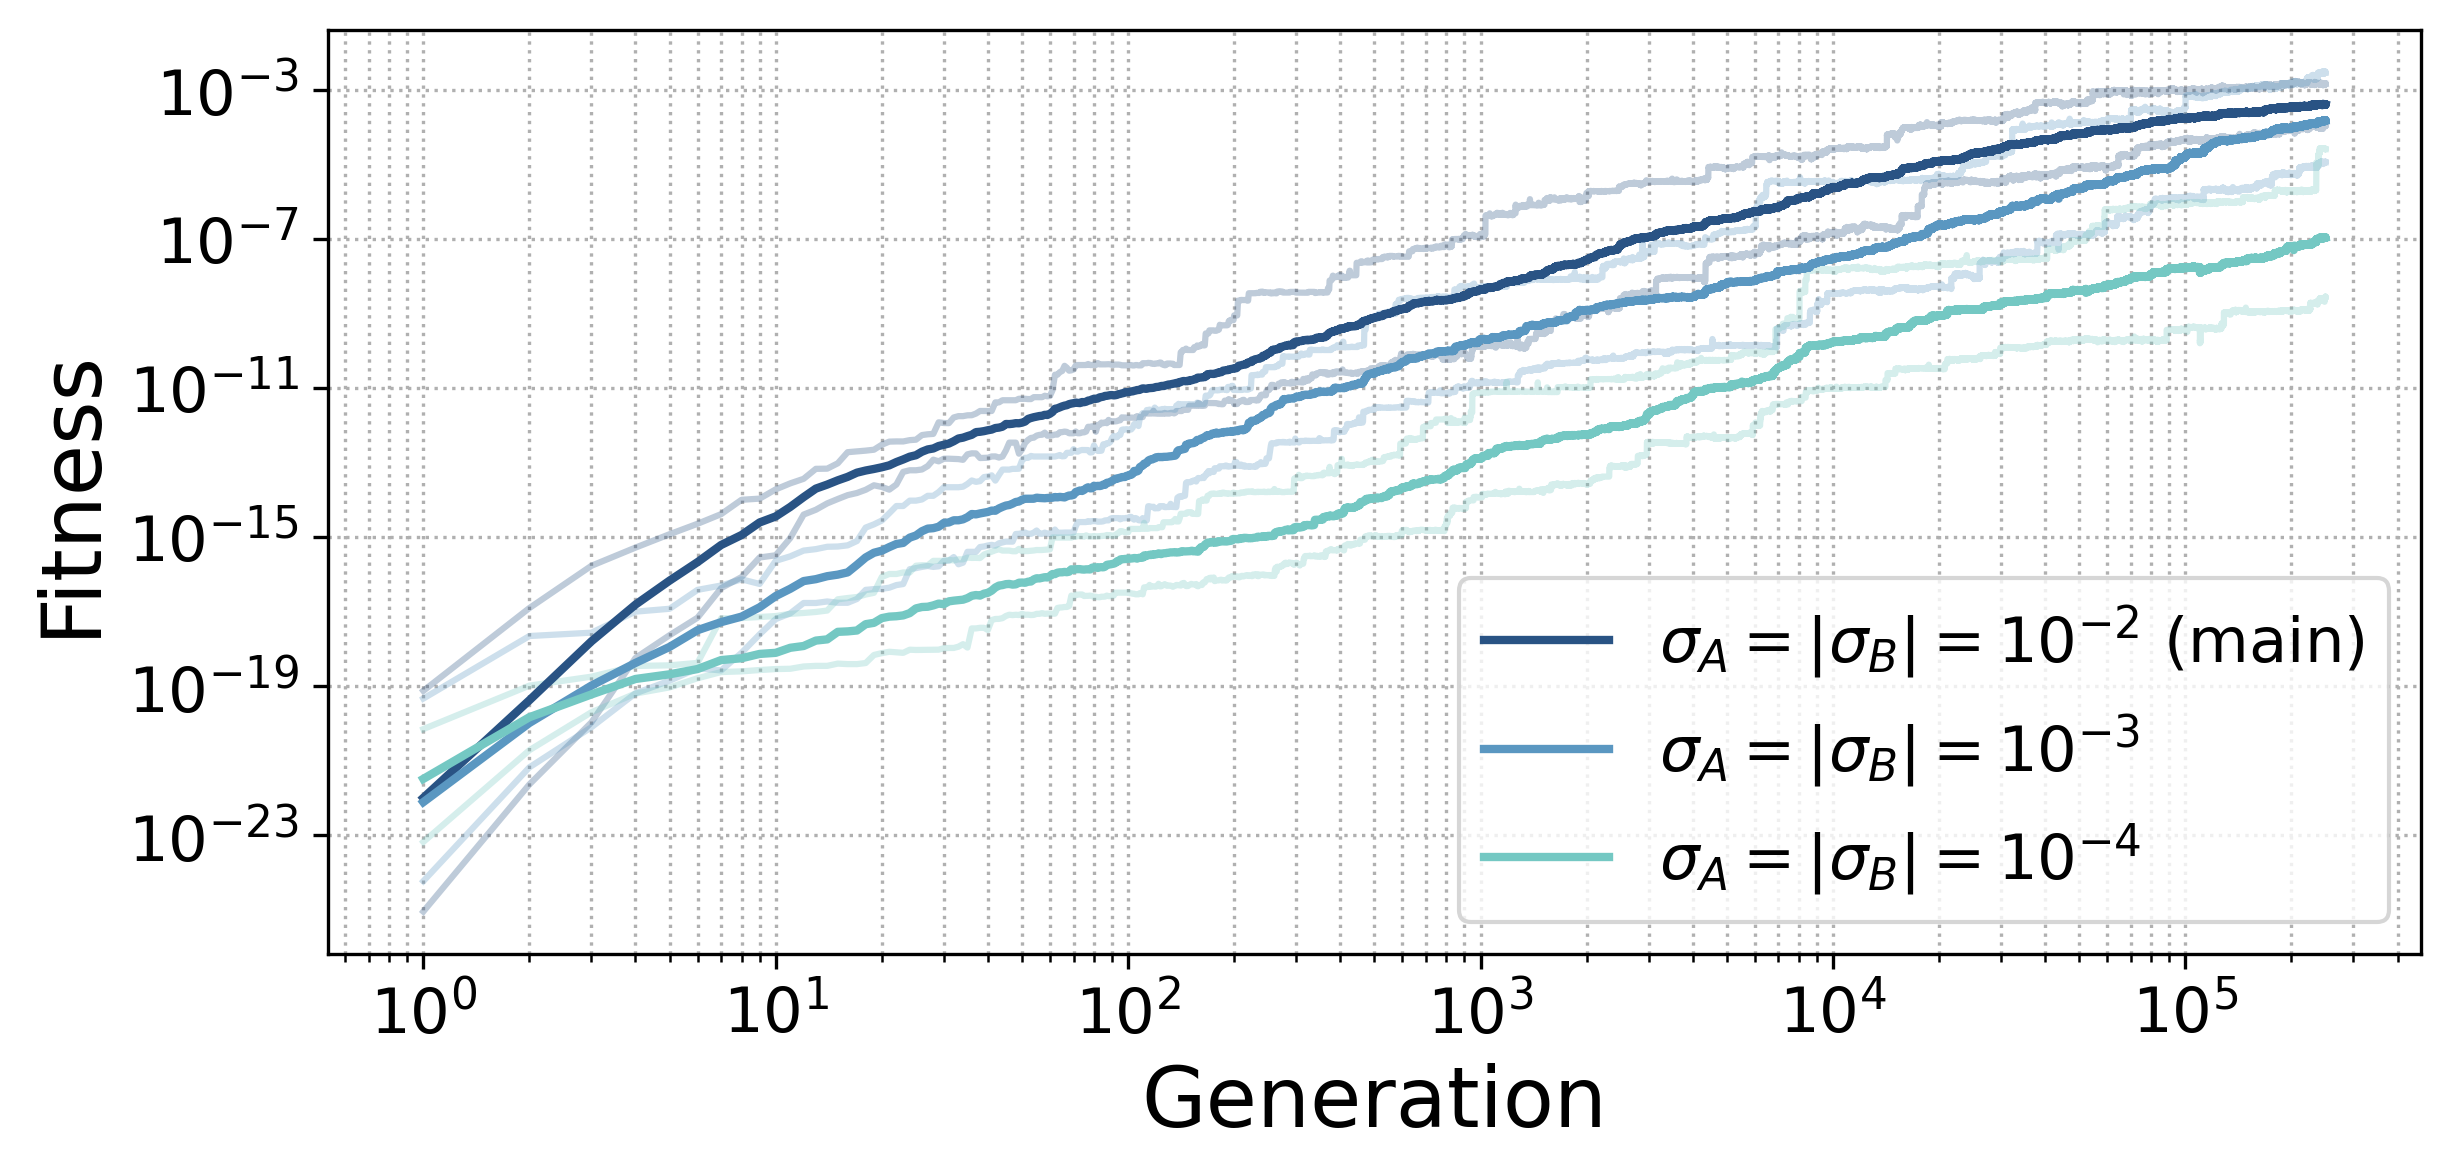

In [17]:
plot_fitness(exp_stats, exp_paths[-1])

# Plot the number of active genes of each type over evolutionary time

In [18]:
def plot_gene_activity_all(i_exp, full_stats, exp_path, var_type='quantile'):
    
    mean_data = full_stats.groupby('Gen').mean().reset_index()
    if var_type == 'sigma':
        std_data = full_stats.groupby('Gen').std()
    elif var_type == 'quantile':
        first_dec = full_stats.groupby('Gen').quantile(0.1)
        last_dec = full_stats.groupby('Gen').quantile(0.9)
    elif var_type == 'minmax':
        min_data = full_stats.groupby('Gen').min()
        max_data = full_stats.groupby('Gen').max()
    
    for env in ["A", "B"]:

        fig, ax1 = plt.subplots(figsize=(9, 4), dpi=dpi)
        delta_y = exp_params[0]["nb_genes"] / 3 * 0.05 
        ax1.set_ylim(-delta_y, exp_params[0]["nb_genes"] / 3 + delta_y)
        ax1.set_ylabel('Activated genes', fontsize=label_fontsize)
        ax1.set_xlabel('Generation', fontsize=label_fontsize)
        ax1.set_xscale('log')
        ax1.grid(linestyle=':')
        ax1.grid(visible=True, which="minor", axis='x', linestyle=':')

        for i_gene_type, gene_type in enumerate(gene_types):

            ax1.plot(mean_data['Gen'], mean_data[f"{gene_type}on_{env}"],
                     color=gene_type_color[i_gene_type],
                     linewidth=2,
                     label=gene_type)
            
            # Show 2-sigma (95%) confidence intervals
            if var_type == 'sigma':
                ax1.plot(mean_data['Gen'],
                         mean_data[f"{gene_type}on_{env}"] - 2 * std_data[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)
                ax1.plot(mean_data['Gen'],
                         mean_data[f"{gene_type}on_{env}"] + 2 * std_data[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)
            # Show first and last deciles
            elif var_type == 'quantile':
                ax1.plot(mean_data['Gen'],
                         first_dec[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)
                ax1.plot(mean_data['Gen'],
                         last_dec[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)
            # Show min and max values
            elif var_type == 'minmax':
                ax1.plot(mean_data['Gen'],
                         min_data[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)
                ax1.plot(mean_data['Gen'],
                         max_data[f"{gene_type}on_{env}"],
                         color=gene_type_color[i_gene_type],
                         alpha=0.3)


        
        ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)


        #plt.title(f"Environment {env}")
        fig.legend(bbox_to_anchor=(0, 0),
                   bbox_transform=ax1.transAxes,
                   loc='lower left',
                   title='$\sigma_A = |\sigma_B| = $' + exp_names[i_exp],
                   title_fontsize=legend_fontsize - 2,
                   fontsize=legend_fontsize)
        
        plt.savefig(f'{exp_path}/gene_activity_env_{env}.pdf', dpi=dpi, bbox_inches='tight')

        plt.show()

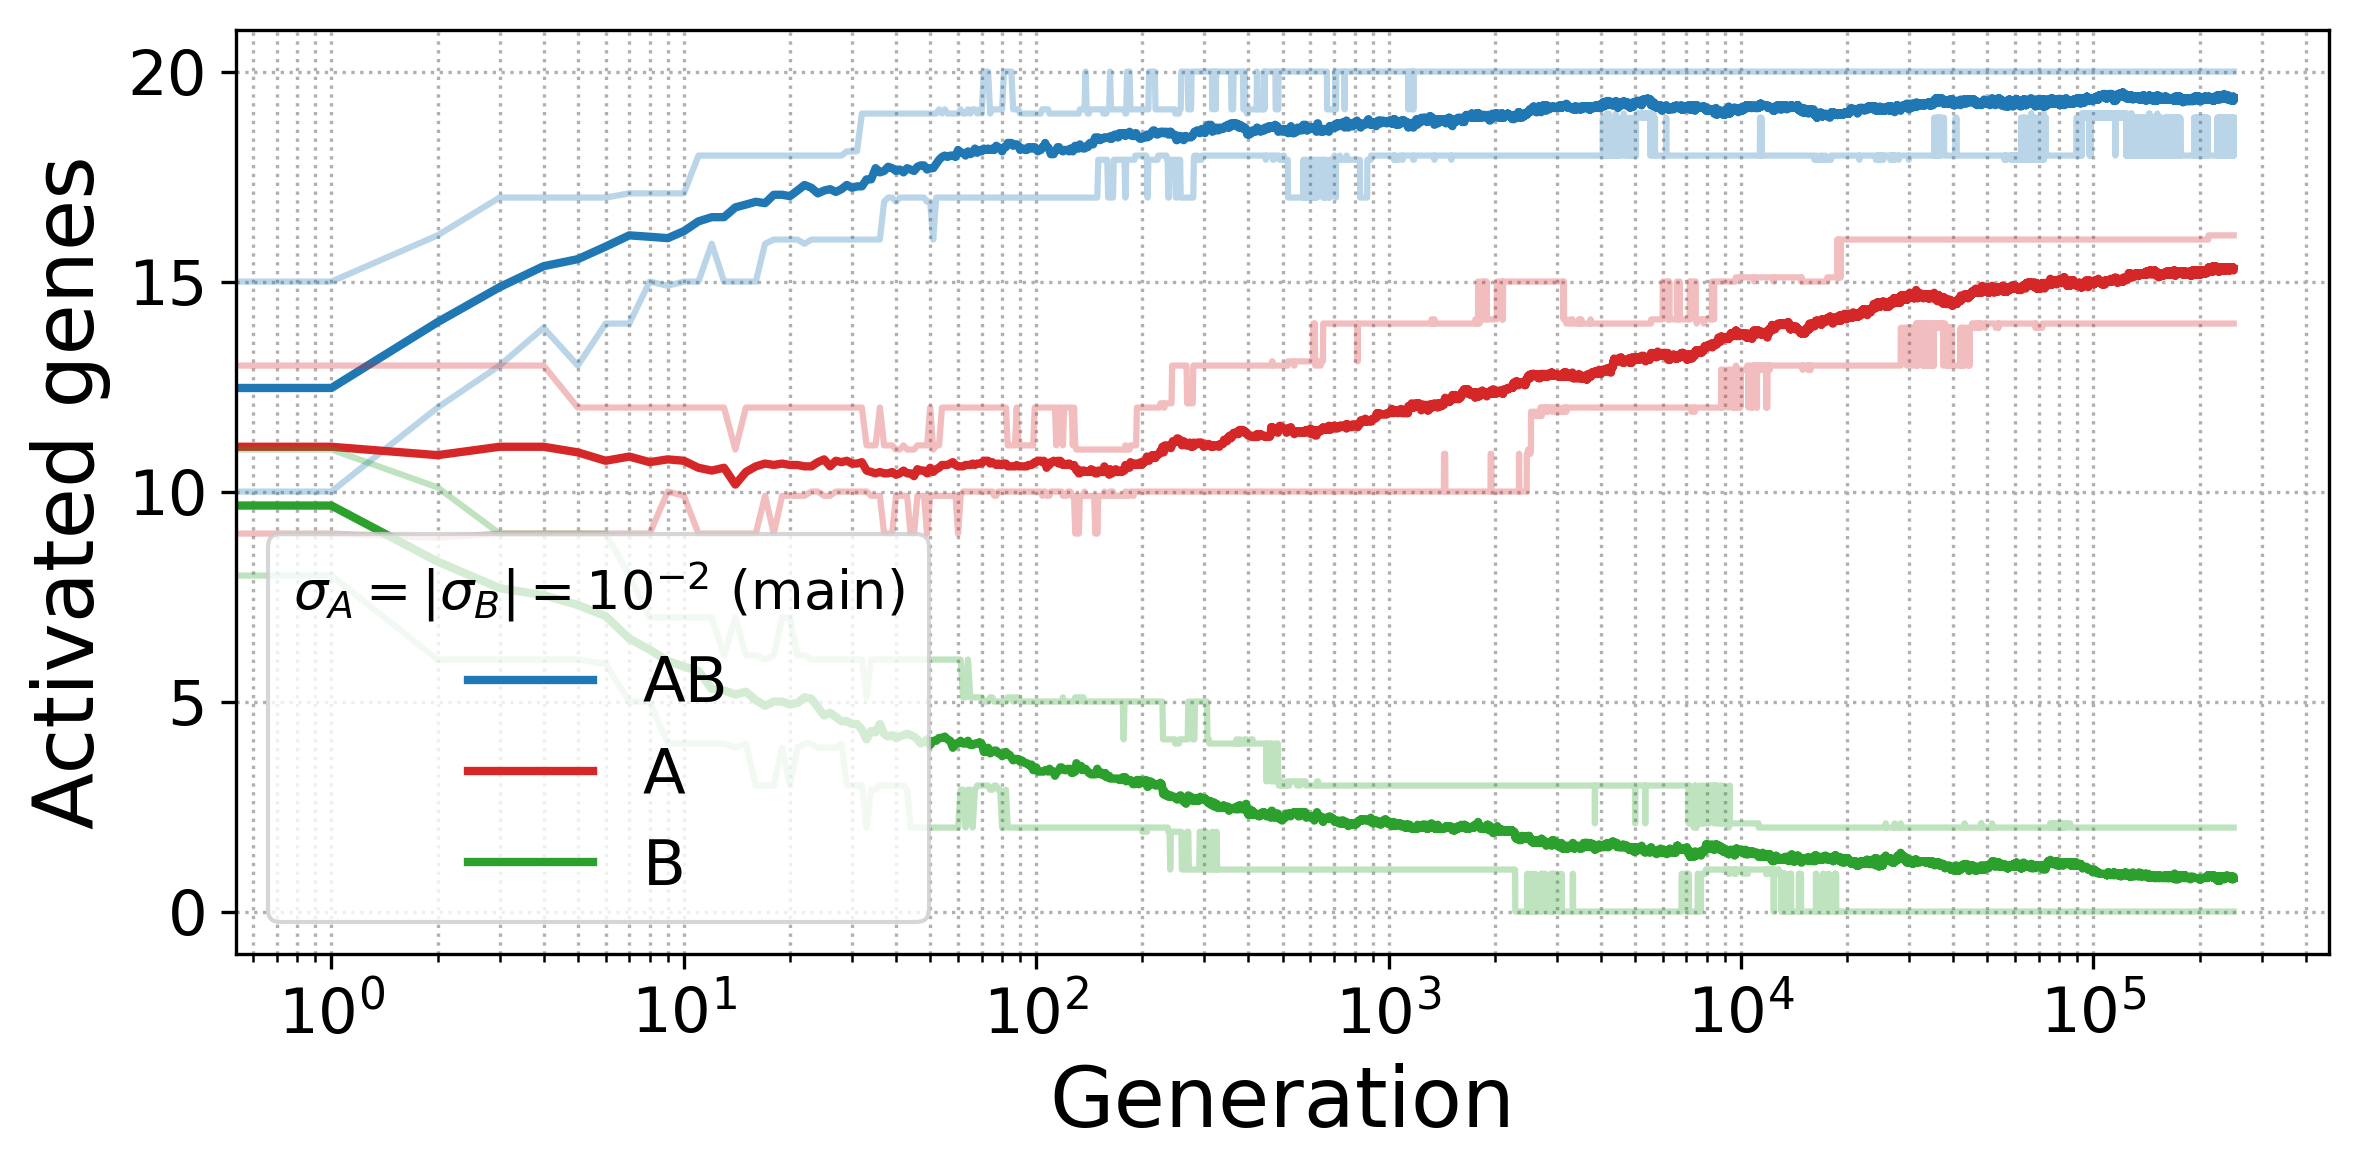

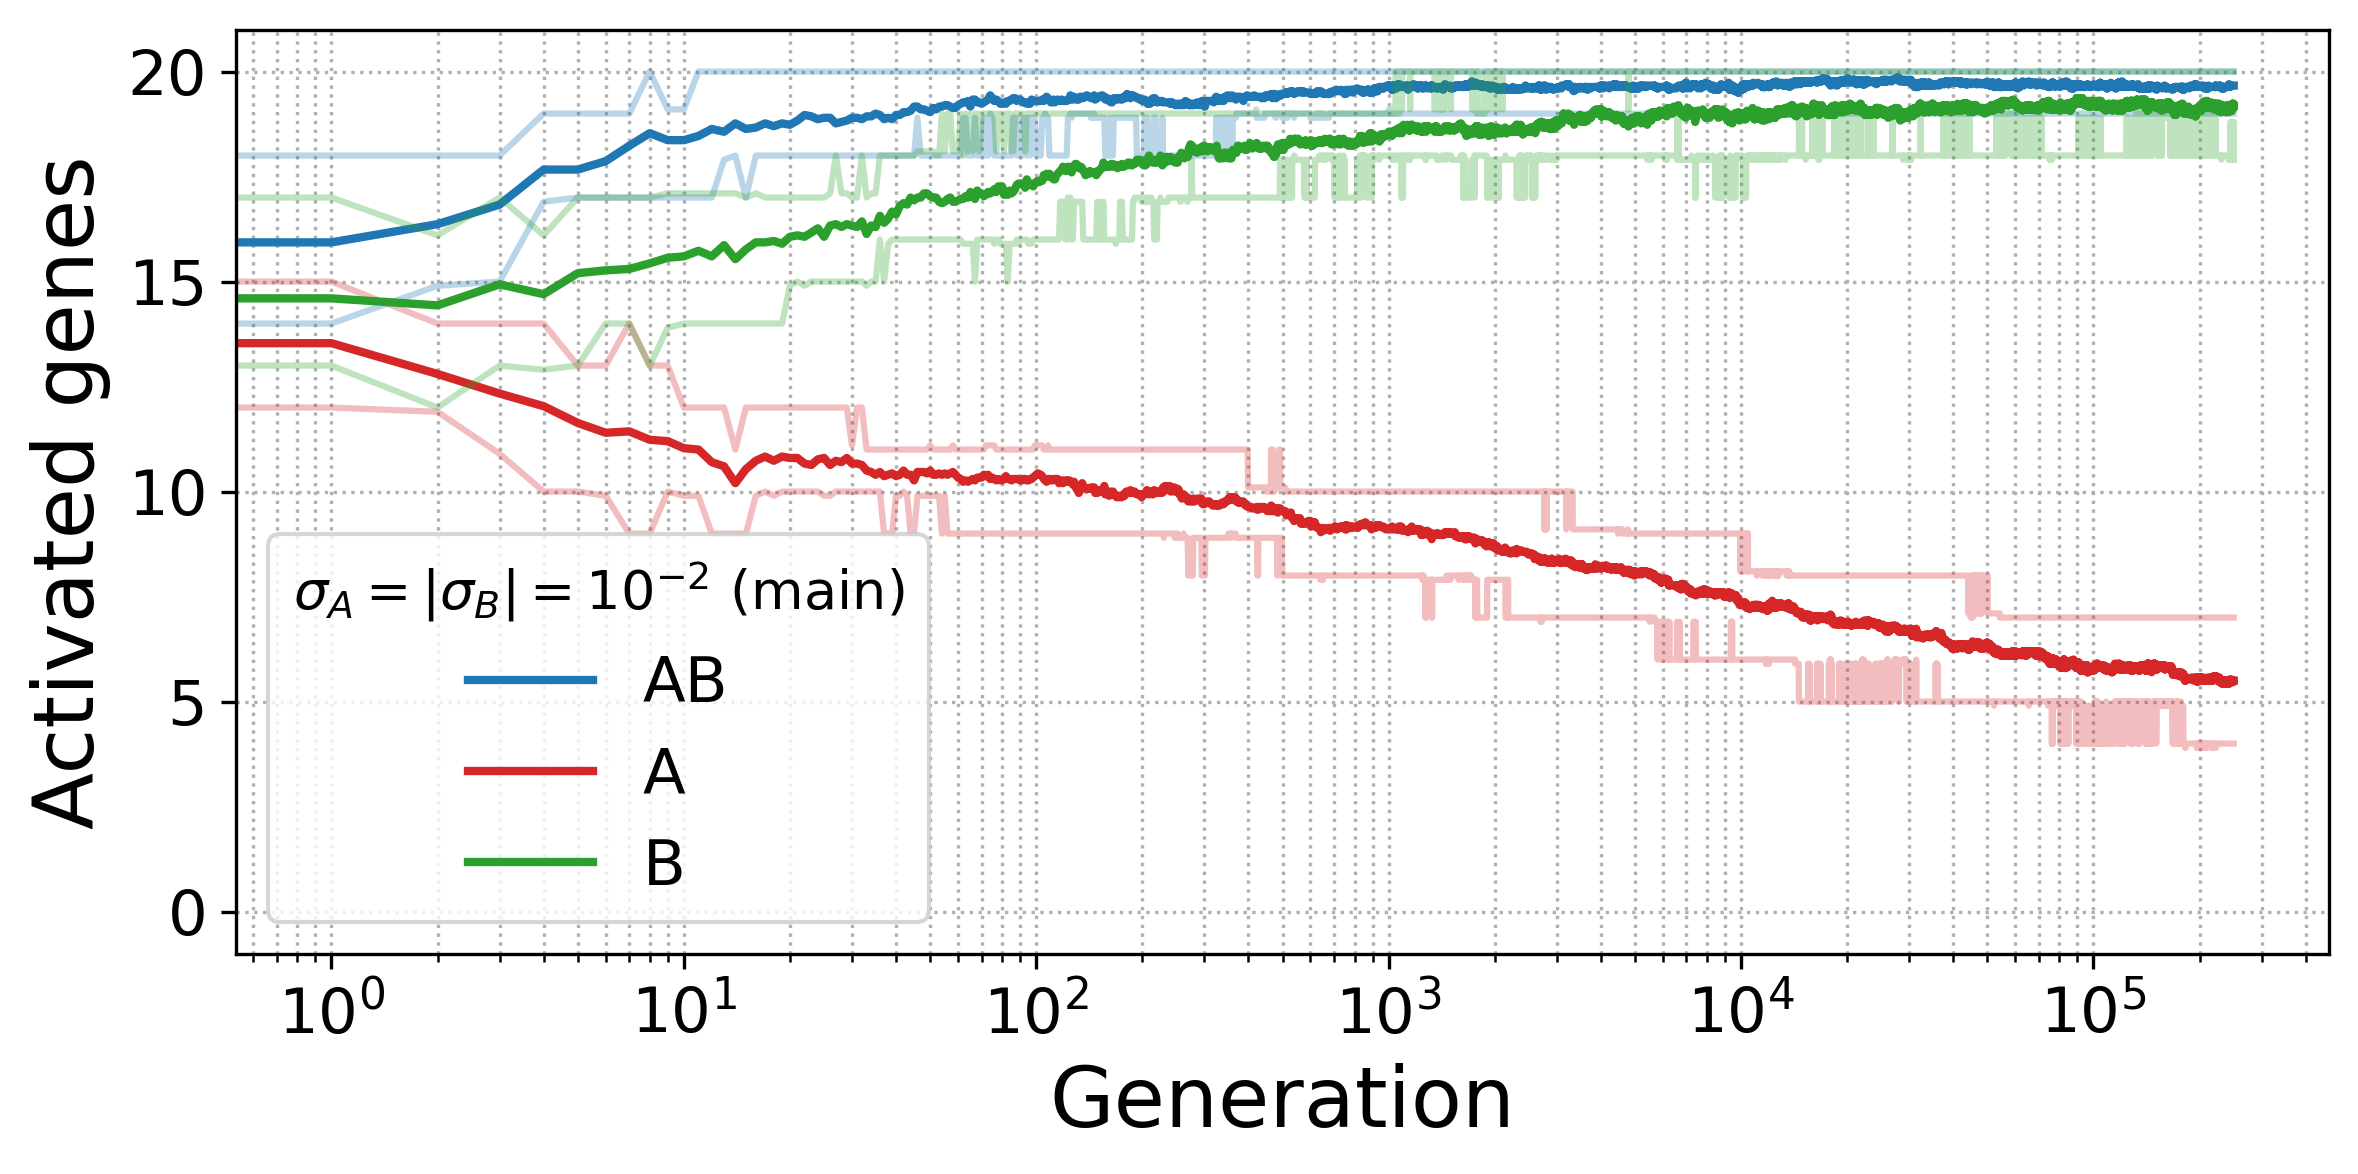

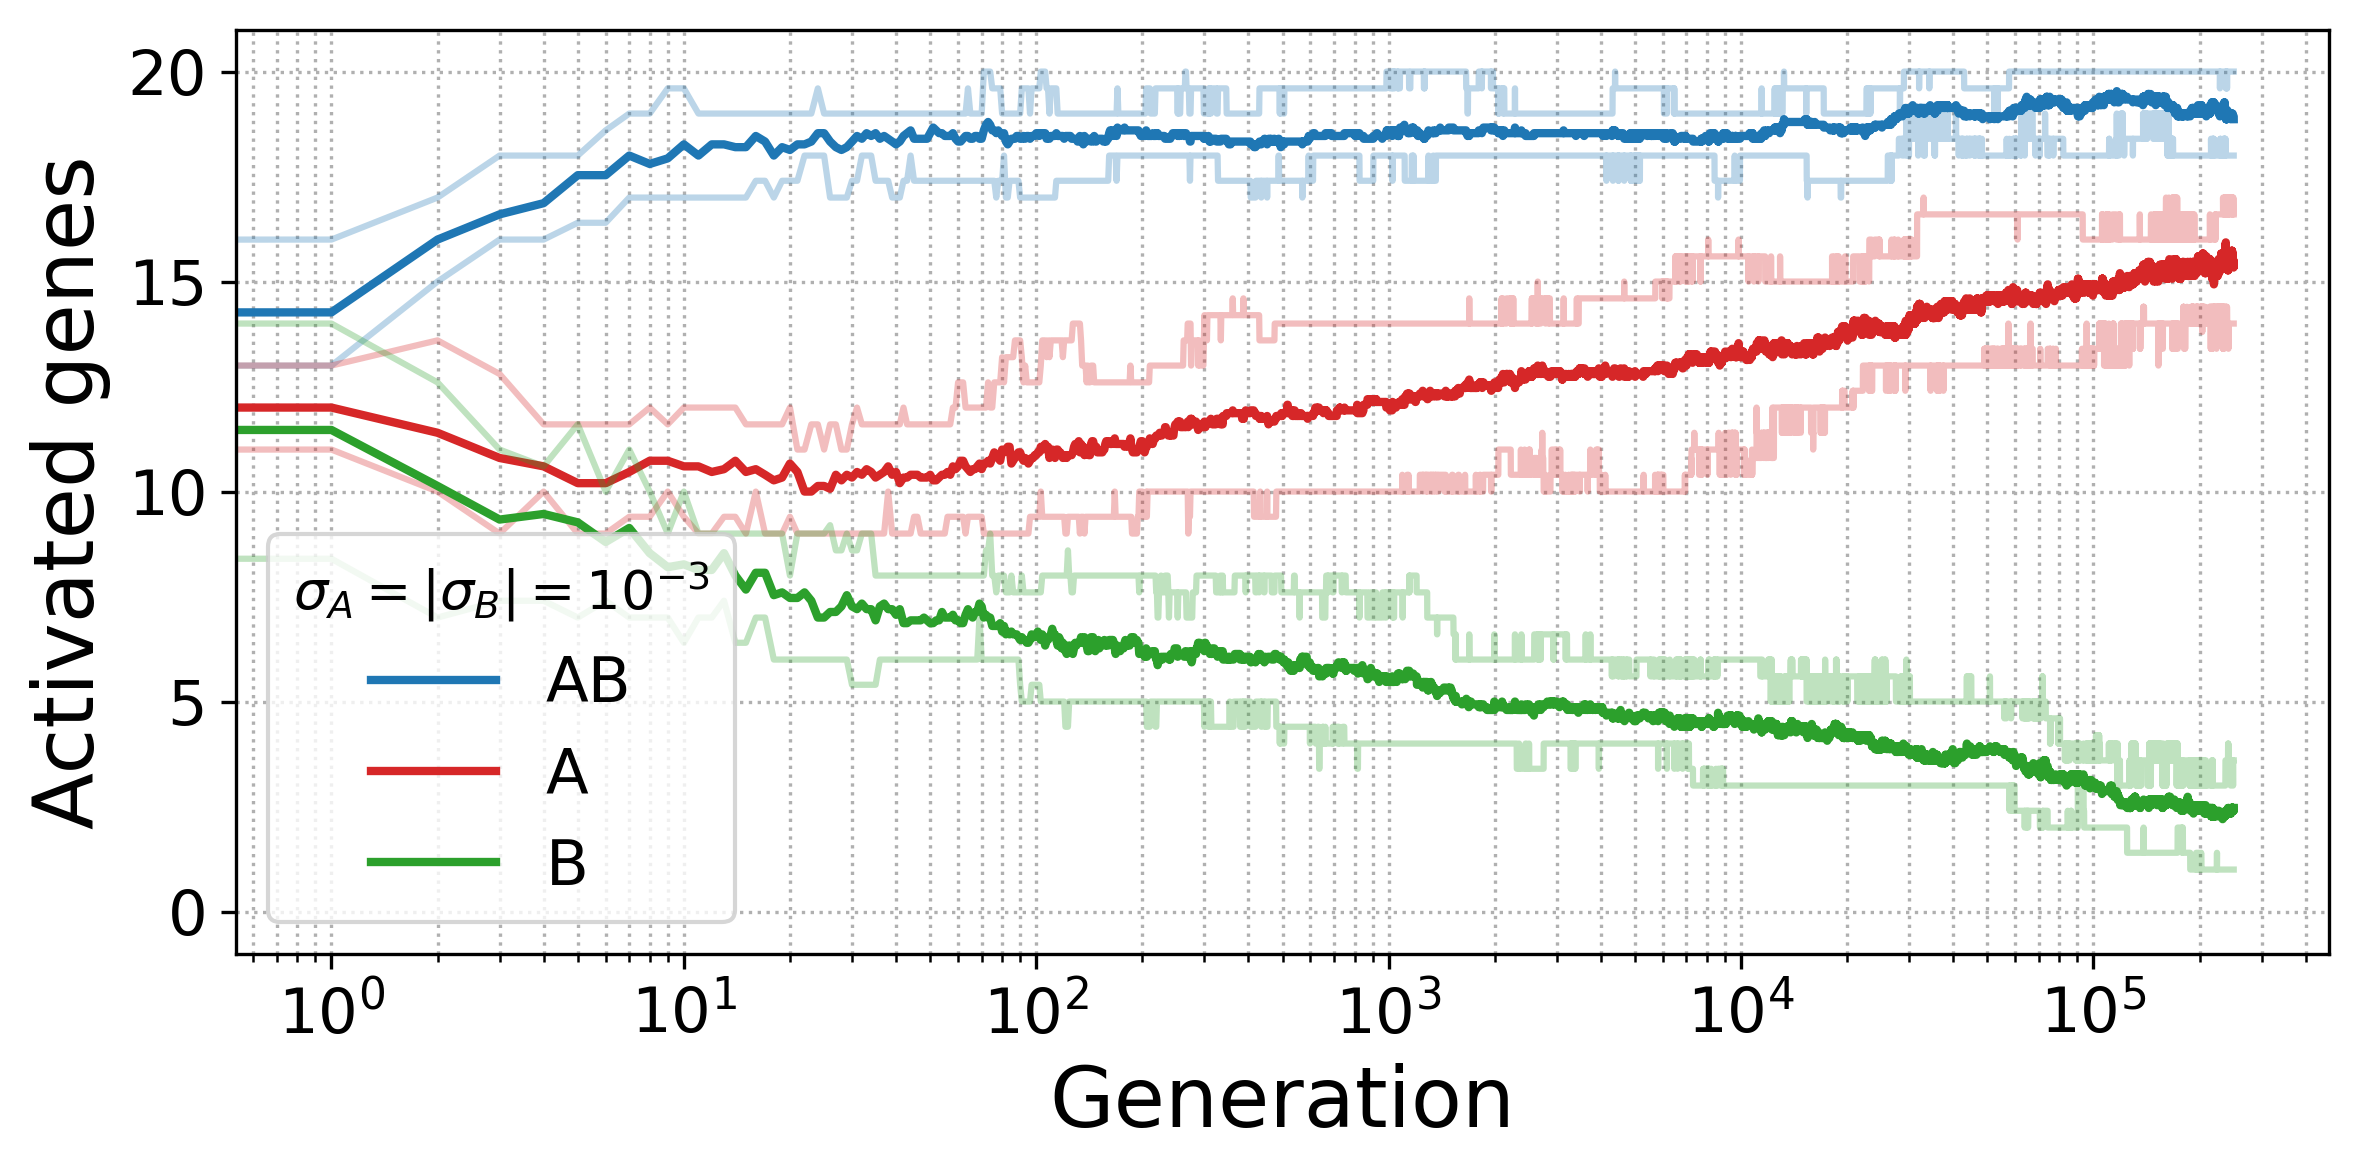

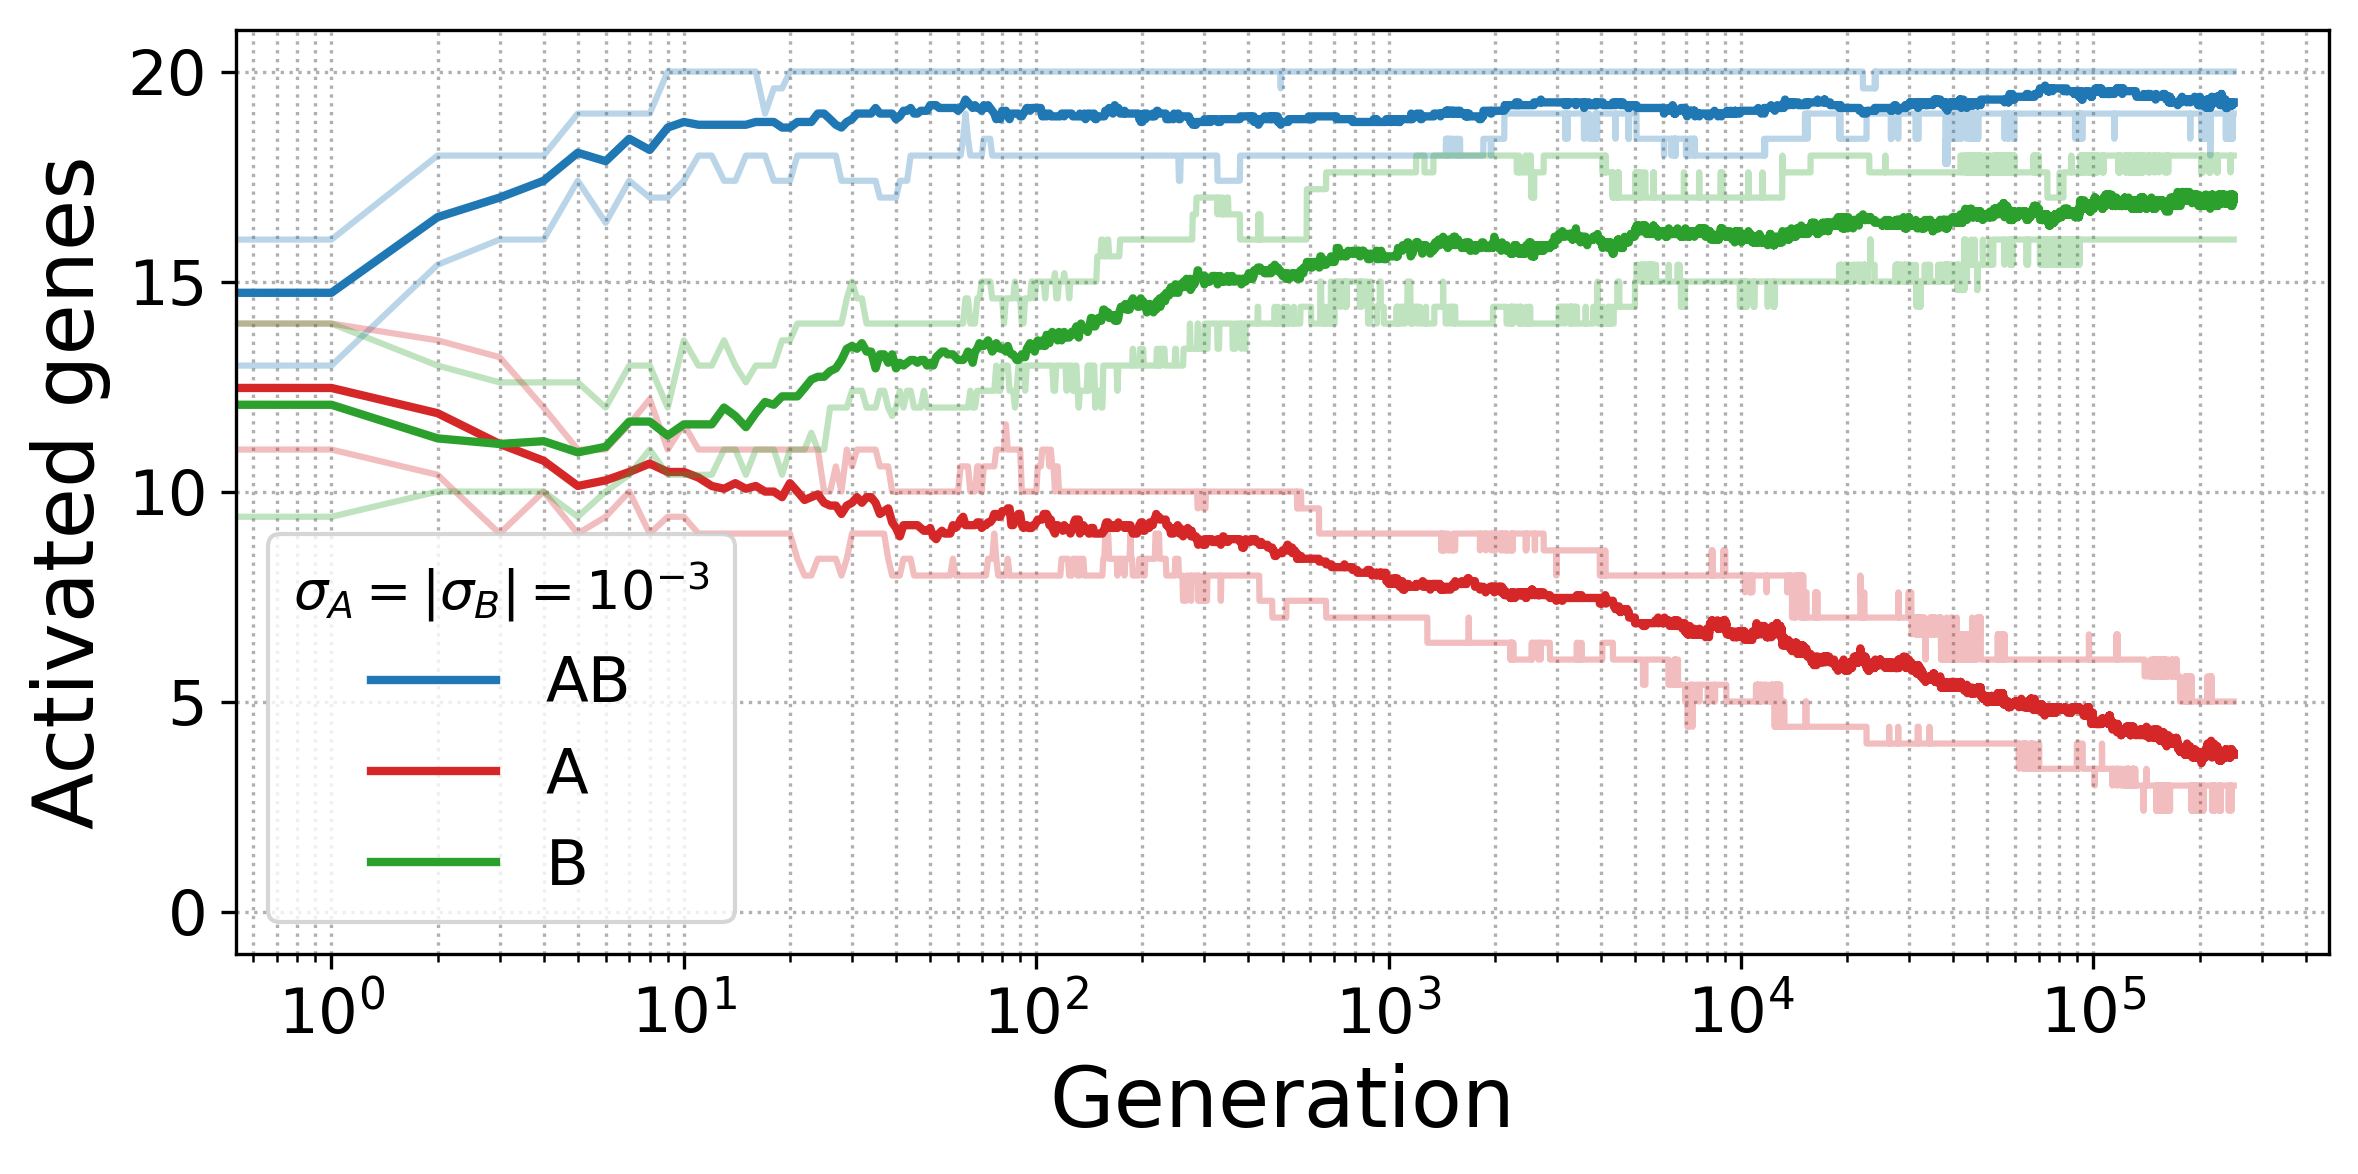

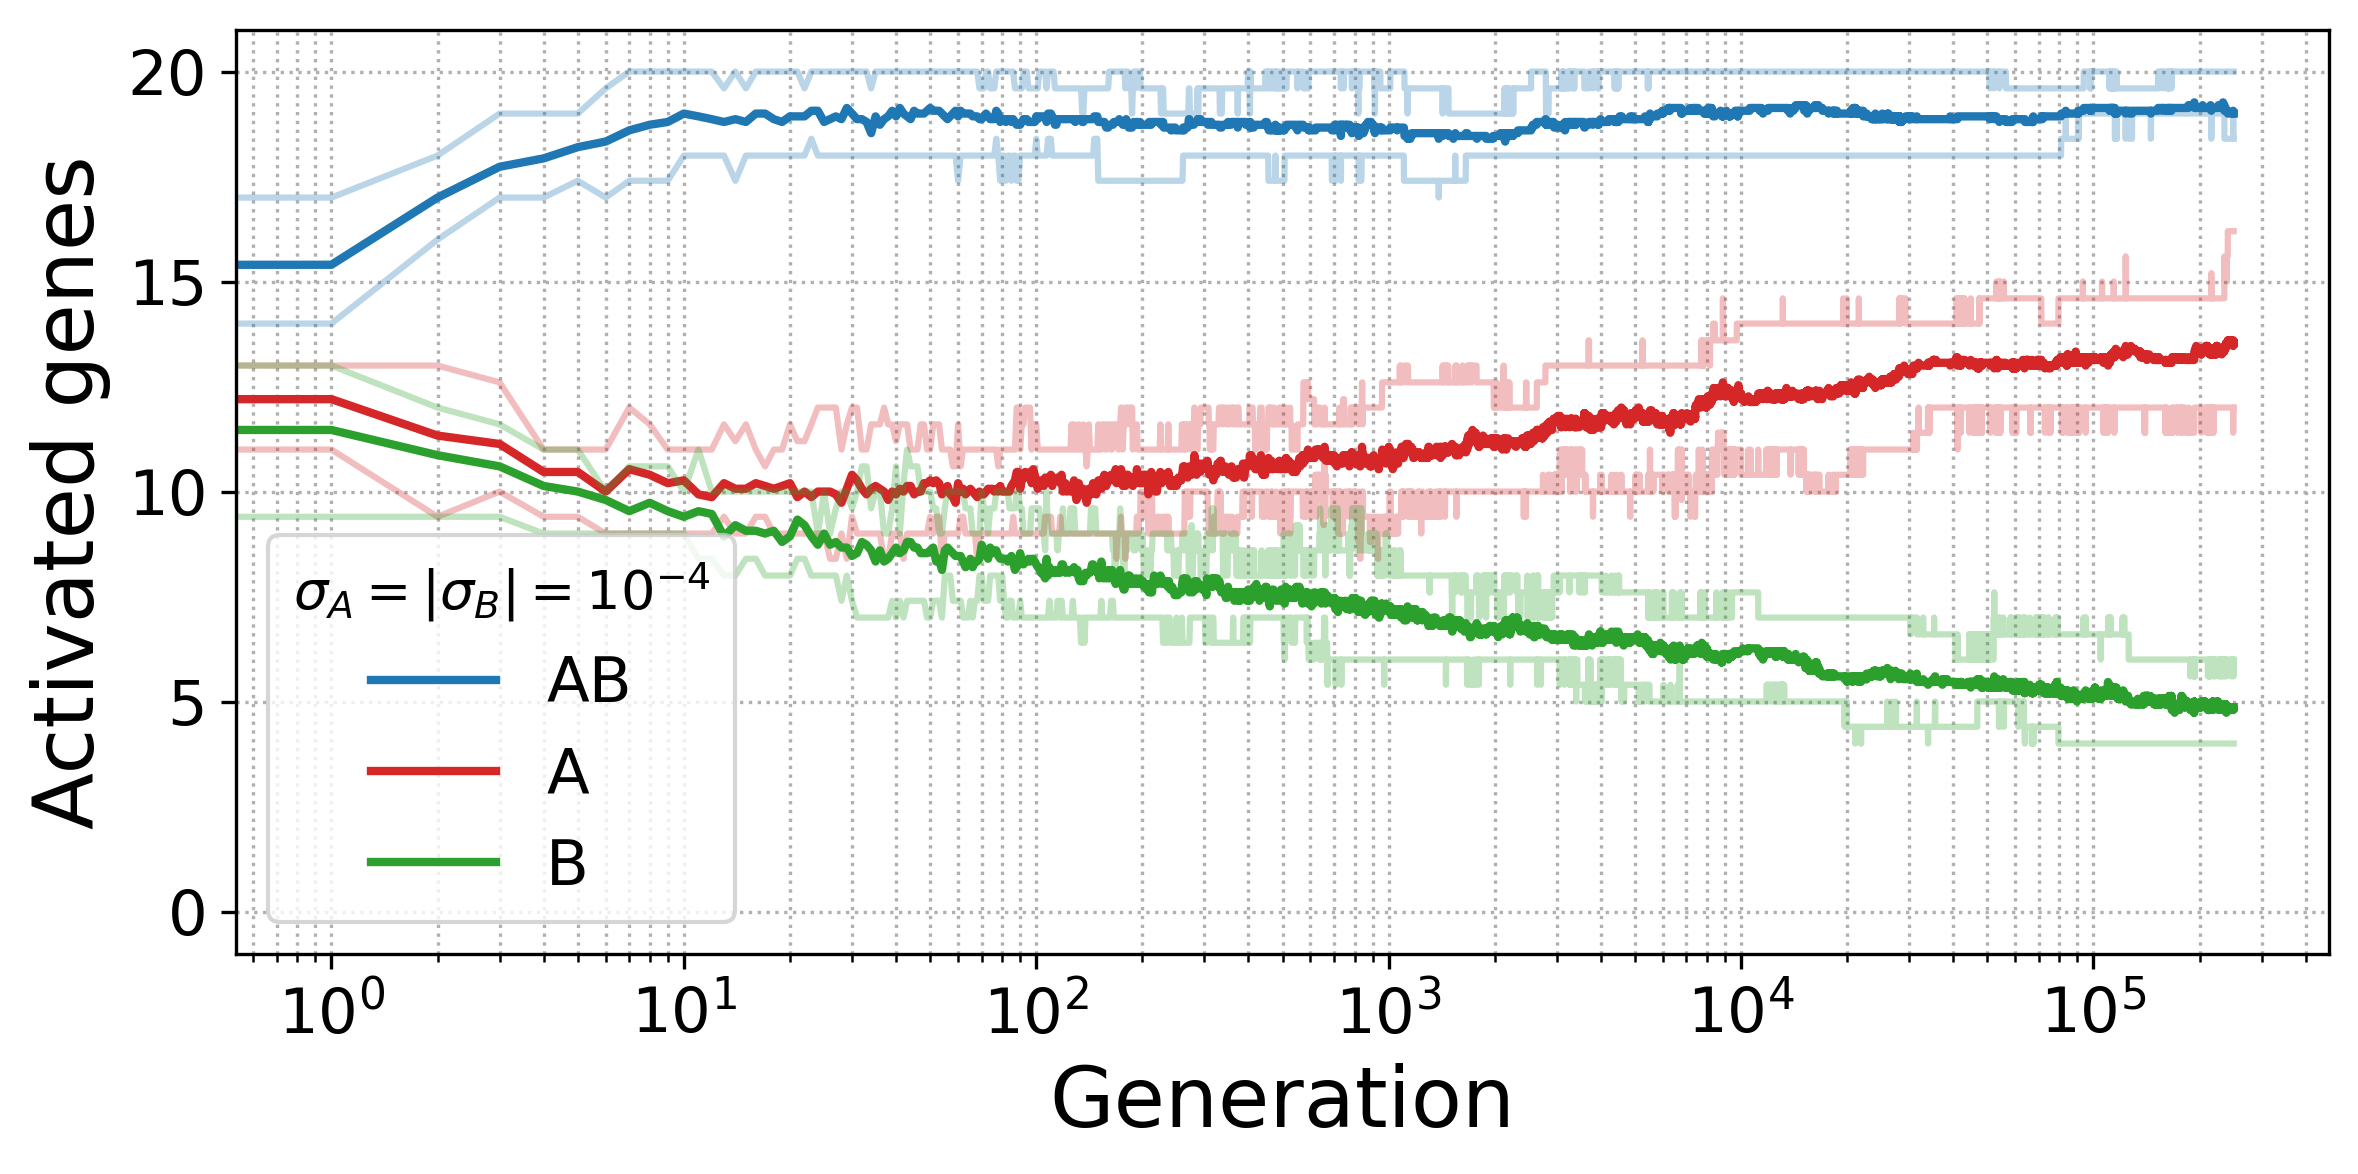

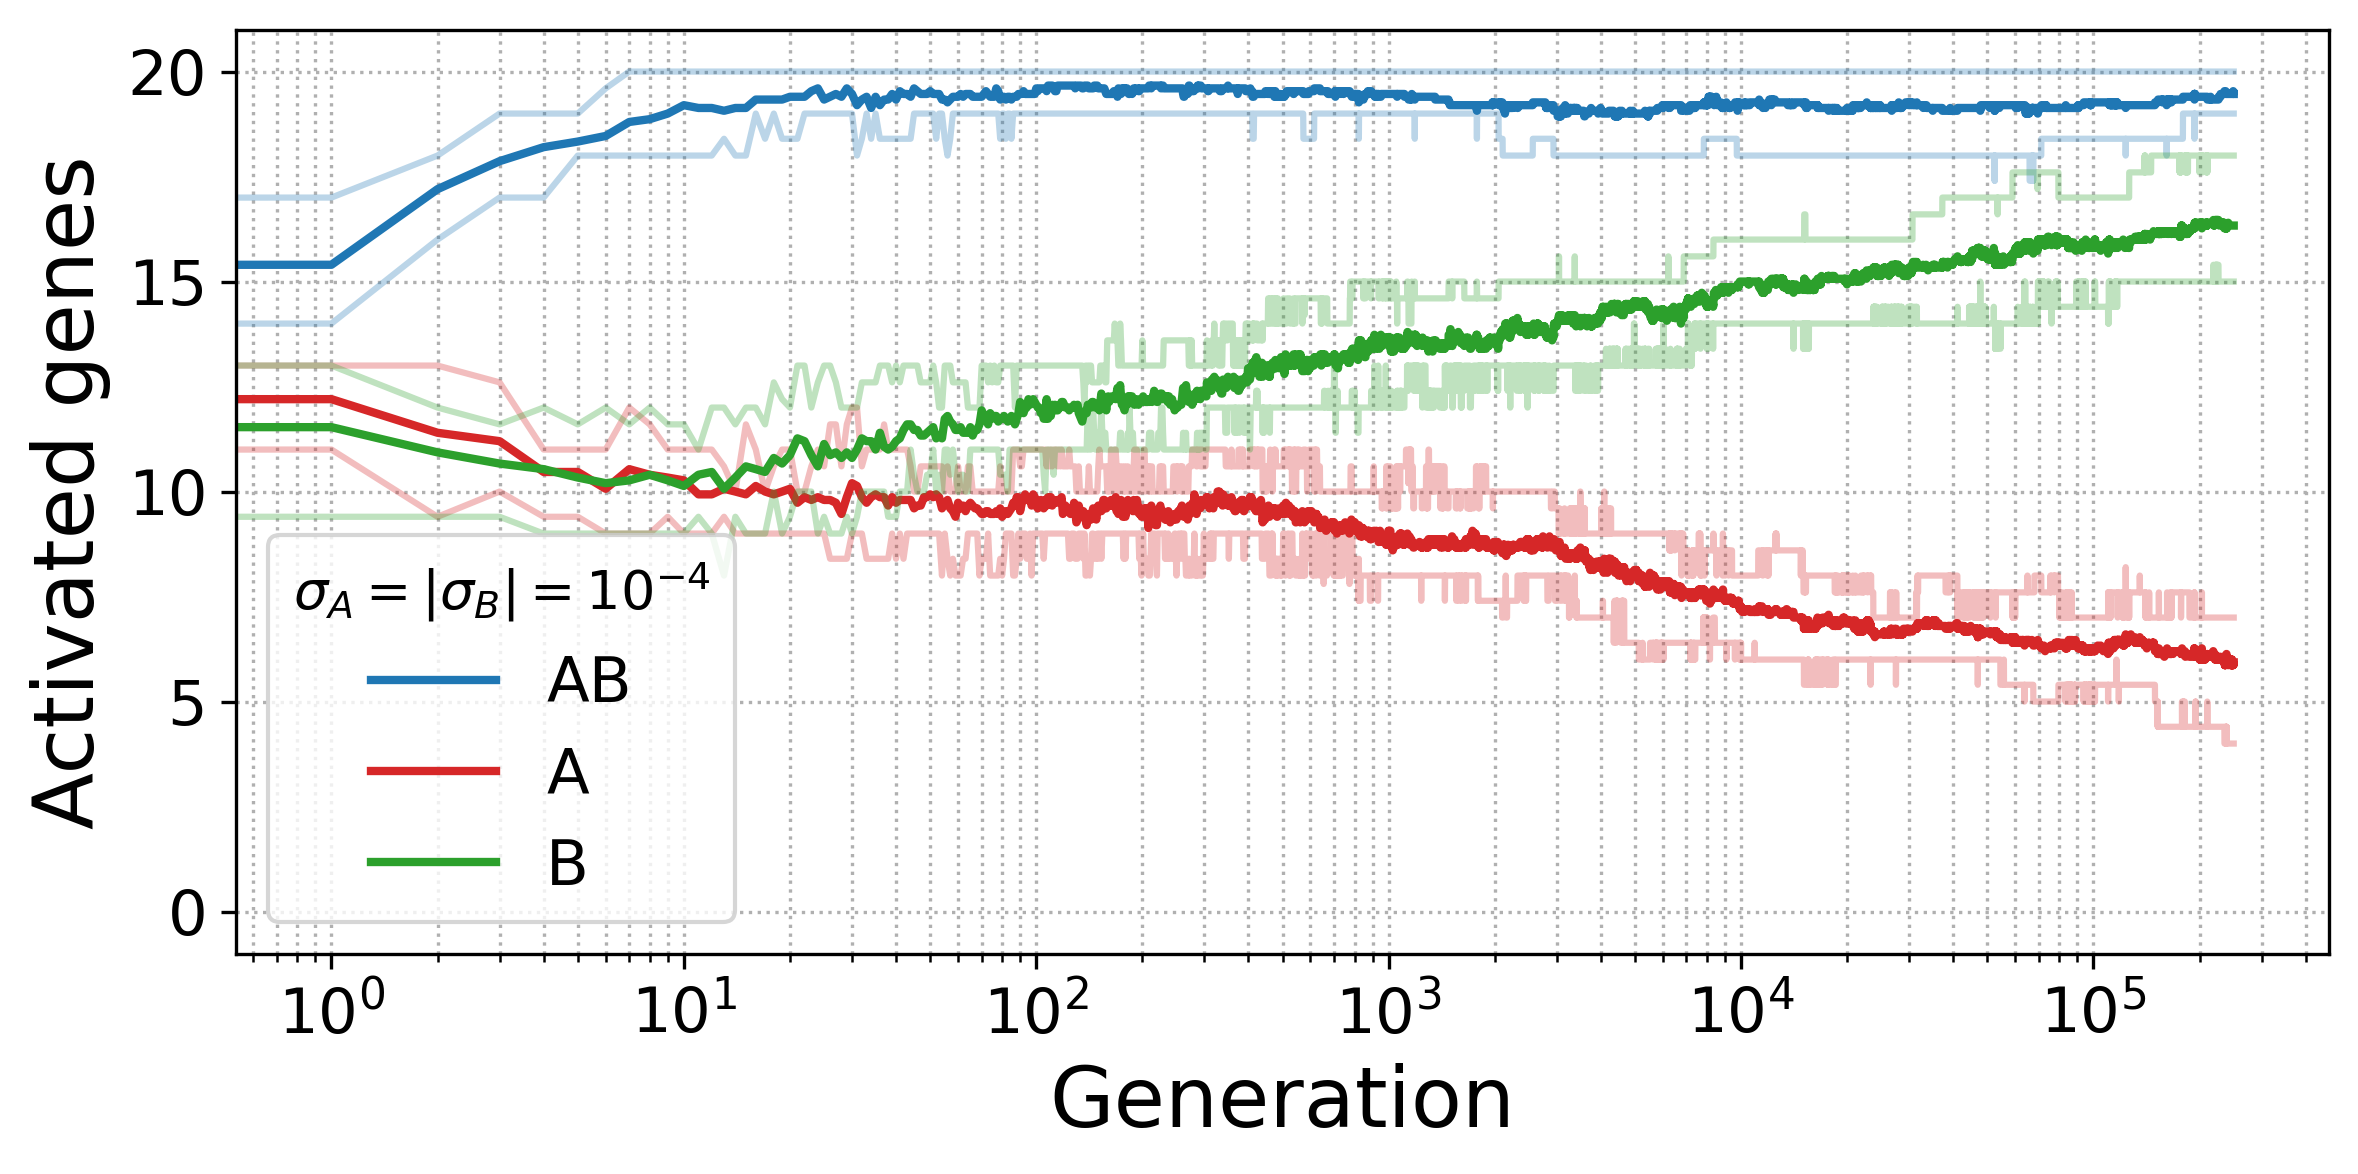

In [19]:
for i_exp in range(len(exp_paths)):
    plot_gene_activity_all(i_exp, exp_stats[i_exp], exp_paths[i_exp])

# Influence of enviromental supercoiling on final gene expression levels

In [20]:
nb_sigmas = 250
sigma_min = -0.061
sigma_max = 0.061

In [21]:
def compute_activity_sigma_per_type(indiv, sigmas):
    
    # Initialize the individual
    indiv.evaluate(0.0, 0.0)

    activ = np.zeros((3, len(sigmas))) # Compute activity for each gene type

    for i_sigma, sigma_env in enumerate(sigmas):
        # Evaluate the individual in the environment with sigma
        temporal_expr = indiv.run_system(sigma_env)

        # Compute total gene activation levels        
        for i_gene, gene in enumerate(indiv.genes):
            activ[gene.gene_type][i_sigma] += temporal_expr[-1, i_gene]
            
    activ /= (indiv.nb_genes / 3)
    
    return activ

In [22]:
def compute_avg_best_activ_by_sigma(exp_path, sigmas):
    rep_dirs = sorted([d for d in exp_path.iterdir() if (d.is_dir() and d.name.startswith("rep"))])

    activ = np.zeros((3, len(sigmas)))
    
    nb_indivs = 0

    for i_rep, rep_dir in enumerate(rep_dirs):
        try:
            indiv = evotsc_lib.get_best_indiv(rep_dir, gen=gen)
        except FileNotFoundError:
            continue
            
        activ += compute_activity_sigma_per_type(indiv, sigmas)
        nb_indivs += 1
            
    return activ / nb_indivs

In [23]:
def generate_rand_activ_by_sigma(params, sigmas):

    activ = np.zeros(len(sigmas))  # Average over all genes, not gene types
    
    rand_indivs = make_random_indivs(nb_indiv=100, params=params)
    
    for i_rand, rand_indiv in enumerate(rand_indivs):
        activ += np.mean(compute_activity_sigma_per_type(rand_indiv, sigmas), axis=0)
        
    return activ / len(rand_indivs)

In [24]:
def plot_activity_sigma_main(ax, sigmas_env, activ, rand_activ, params):
    
    sigma_basal = params['sigma_basal']
    sigma_opt = params['sigma_opt']      

    
    colors = ['tab:blue', 'tab:red', 'tab:green'] # AB: blue, A: red, B: green

    ax.set_xlabel('Background supercoiling ($\sigma_{basal} + \delta\sigma_{env}$)')
    ax.set_ylabel('Average gene expression by type')
    ax.set_ylim(-0.05, 1.10)
    ax.set_xlim(sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal)
    ax.grid(linestyle=':')
    
    # Add 1/2 expression level
    half_expr = (1 + np.exp(- params['m'])) / 2
    ax.hlines(half_expr, sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal,
               linestyle=':', linewidth=1.5, color='tab:pink')#, label='Activation threshold')
    
    
    # Add average expression per gene type
    for i_gene_type, gene_type in enumerate(gene_types):
        ax.plot(sigmas_env + sigma_basal, activ[i_gene_type, :],
                color=gene_type_color[i_gene_type],
                linewidth=2,
                label=gene_type)

    # Add sigma_A and sigma_B
    y_min, y_max = plt.ylim()
    ax.vlines(params['sigma_A'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black') 
    ax.vlines(params['sigma_B'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black')

    if np.abs(params['sigma_A'] - params['sigma_B']) > 0.01: # Default case
        ax.text(params['sigma_A'] + sigma_basal, y_max + 0.005, '$\sigma_A$',
                 va='bottom', ha='center', fontsize='large') # Use \mathbf{} for bold
        ax.text(params['sigma_B'] + sigma_basal, y_max + 0.005, '$\sigma_B$',
                 va='bottom', ha='center', fontsize='large')
        
    elif np.abs(params['sigma_A'] - params['sigma_B']) > 0.001:
        ax.text(params['sigma_A'] + sigma_basal, y_max + 0.002, '$\sigma_A$',
                 va='bottom', ha='left', fontsize='medium') # Use \mathbf{} for bold
        ax.text(params['sigma_B'] + sigma_basal, y_max + 0.002, '$\sigma_B$',
                 va='bottom', ha='right', fontsize='medium')

    else: # Too close
        ax.text(params['sigma_A'] + sigma_basal, y_max - 0.002, '$\sigma_{B/A}$',
                 va='bottom', ha='left', fontsize='medium') # Use \mathbf{} for bold

    ax.set_ylim(y_min, y_max)
    
    # Add expression for a random genome
    ax.plot(sigmas_env + sigma_basal, rand_activ,
            linewidth=2, color='tab:cyan', zorder=0, linestyle=(0, (3, 1, 1, 1)), label='Random')
    
    # Add expression for an isolated gene
    sigmas_total = sigmas_env + sigma_basal
    activities = 1.0 / (1.0 + np.exp((sigmas_total - sigma_opt)/ params['epsilon']))
    ax.plot(sigmas_env + sigma_basal, np.exp(params['m'] * (activities - 1)),
             linewidth=2, color='tab:cyan', zorder=0, linestyle='--', label='Isolated gene')

    ax.legend(loc='lower left')
    
    # Add other ax with other sc
    ax2 = ax.twiny()
    xmin, xmax = ax.get_xlim()
    ax2.set_xlim(xmin - params['sigma_basal'], xmax - params['sigma_basal'])
    ax2.set_xlabel('Environmental shift in supercoiling ($\delta\sigma_{env}$)')

In [25]:
def plot_activity_sigma_inset(ax, sigmas_env, activ, rand_activ, params):
    
    inset_ax = inset_axes(ax, width="20%", height="50%", loc='upper right', borderpad=0.9)
    
    sigma_basal = params['sigma_basal']
    sigma_opt = params['sigma_opt']      
    
    colors = ['tab:blue', 'tab:red', 'tab:green'] # AB: blue, A: red, B: green

    #inset_ax.set_ylim(-0.05, 1.10)
    inset_ax.set_ylim(0.25, 0.85)
    inset_ax.set_xlim(sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal)
    inset_ax.grid(linestyle=':')
    
    inset_ax.tick_params(labelsize='small')
    #inset_ax.ticklabel_format(axis='x', scilimits=(0,0))
    inset_ax.tick_params(axis='x', labelrotation=-45)
    #y_ticks = inset_ax.yaxis.get_major_ticks()
    #for i_tick, tick in enumerate(y_ticks[:-2]):
    #    if i_tick != 1:
    #        tick.label1.set_visible(False)
    
    # Add 1/2 expression level
    half_expr = (1 + np.exp(- params['m'])) / 2
    inset_ax.hlines(half_expr, sigmas_env[0] + sigma_basal, sigmas_env[-1] + sigma_basal,
               linestyle=':', linewidth=1.5, color='tab:pink')#, label='Activation threshold')
    
    
    # Add average expression per gene type
    for i_gene_type, gene_type in enumerate(gene_types):
        inset_ax.plot(sigmas_env + sigma_basal, activ[i_gene_type, :],
                color=gene_type_color[i_gene_type],
                linewidth=2,
                label=gene_type)

    # Add sigma_A and sigma_B
    y_min, y_max = plt.ylim()
    inset_ax.vlines(params['sigma_A'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black')
    inset_ax.vlines(params['sigma_B'] + sigma_basal, y_min, y_max, linestyle='--', linewidth=1, color='black')
    
    inset_ax.text(params['sigma_A'] + sigma_basal, y_max + 0.001, '$\sigma_A$',
             va='bottom', ha='center', fontsize='small') # Use \mathbf{} for bold
    inset_ax.text(params['sigma_B'] + sigma_basal, y_max + 0.001, '$\sigma_B$',
             va='bottom', ha='center', fontsize='small')
    inset_ax.set_ylim(y_min, y_max)
    
    # Add expression for a random genome
    inset_ax.plot(sigmas_env + sigma_basal, rand_activ,
            linewidth=2, color='tab:cyan', zorder=0, linestyle=(0, (3, 1, 1, 1)), label='Random')
    
    # Add expression for an isolated gene
    sigmas_total = sigmas_env + sigma_basal
    activities = 1.0 / (1.0 + np.exp((sigmas_total - sigma_opt)/ params['epsilon']))
    inset_ax.plot(sigmas_env + sigma_basal, np.exp(params['m'] * (activities - 1)),
             linewidth=2, color='tab:cyan', zorder=0, linestyle='--', label='Isolated gene')


In [26]:
# See how gene activity levels depend on environmental supercoiling
def plot_activity_sigma_per_type(exp_path, params, insert_inset=False, plot_name=None):

    sigmas = np.linspace(sigma_min, sigma_max, nb_sigmas)
    
    activ = compute_avg_best_activ_by_sigma(exp_path, sigmas)
    rand_activ = generate_rand_activ_by_sigma(params, sigmas)
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=dpi)
    
    plot_activity_sigma_main(ax, sigmas, activ, rand_activ, params)
    
    if insert_inset:
        
        sigmas_inset = np.linspace(sigma_min / 150, sigma_max / 150, nb_sigmas)
        activ_inset = compute_avg_best_activ_by_sigma(exp_path, sigmas_inset)
        rand_activ_inset = generate_rand_activ_by_sigma(params, sigmas_inset)

        plot_activity_sigma_inset(ax, sigmas_inset, activ_inset, rand_activ_inset, params)
    
    # Wrap up            
    if plot_name:
        plt.savefig(exp_path.joinpath(plot_name), dpi=dpi, bbox_inches='tight')
        
    plt.show()
    plt.close()

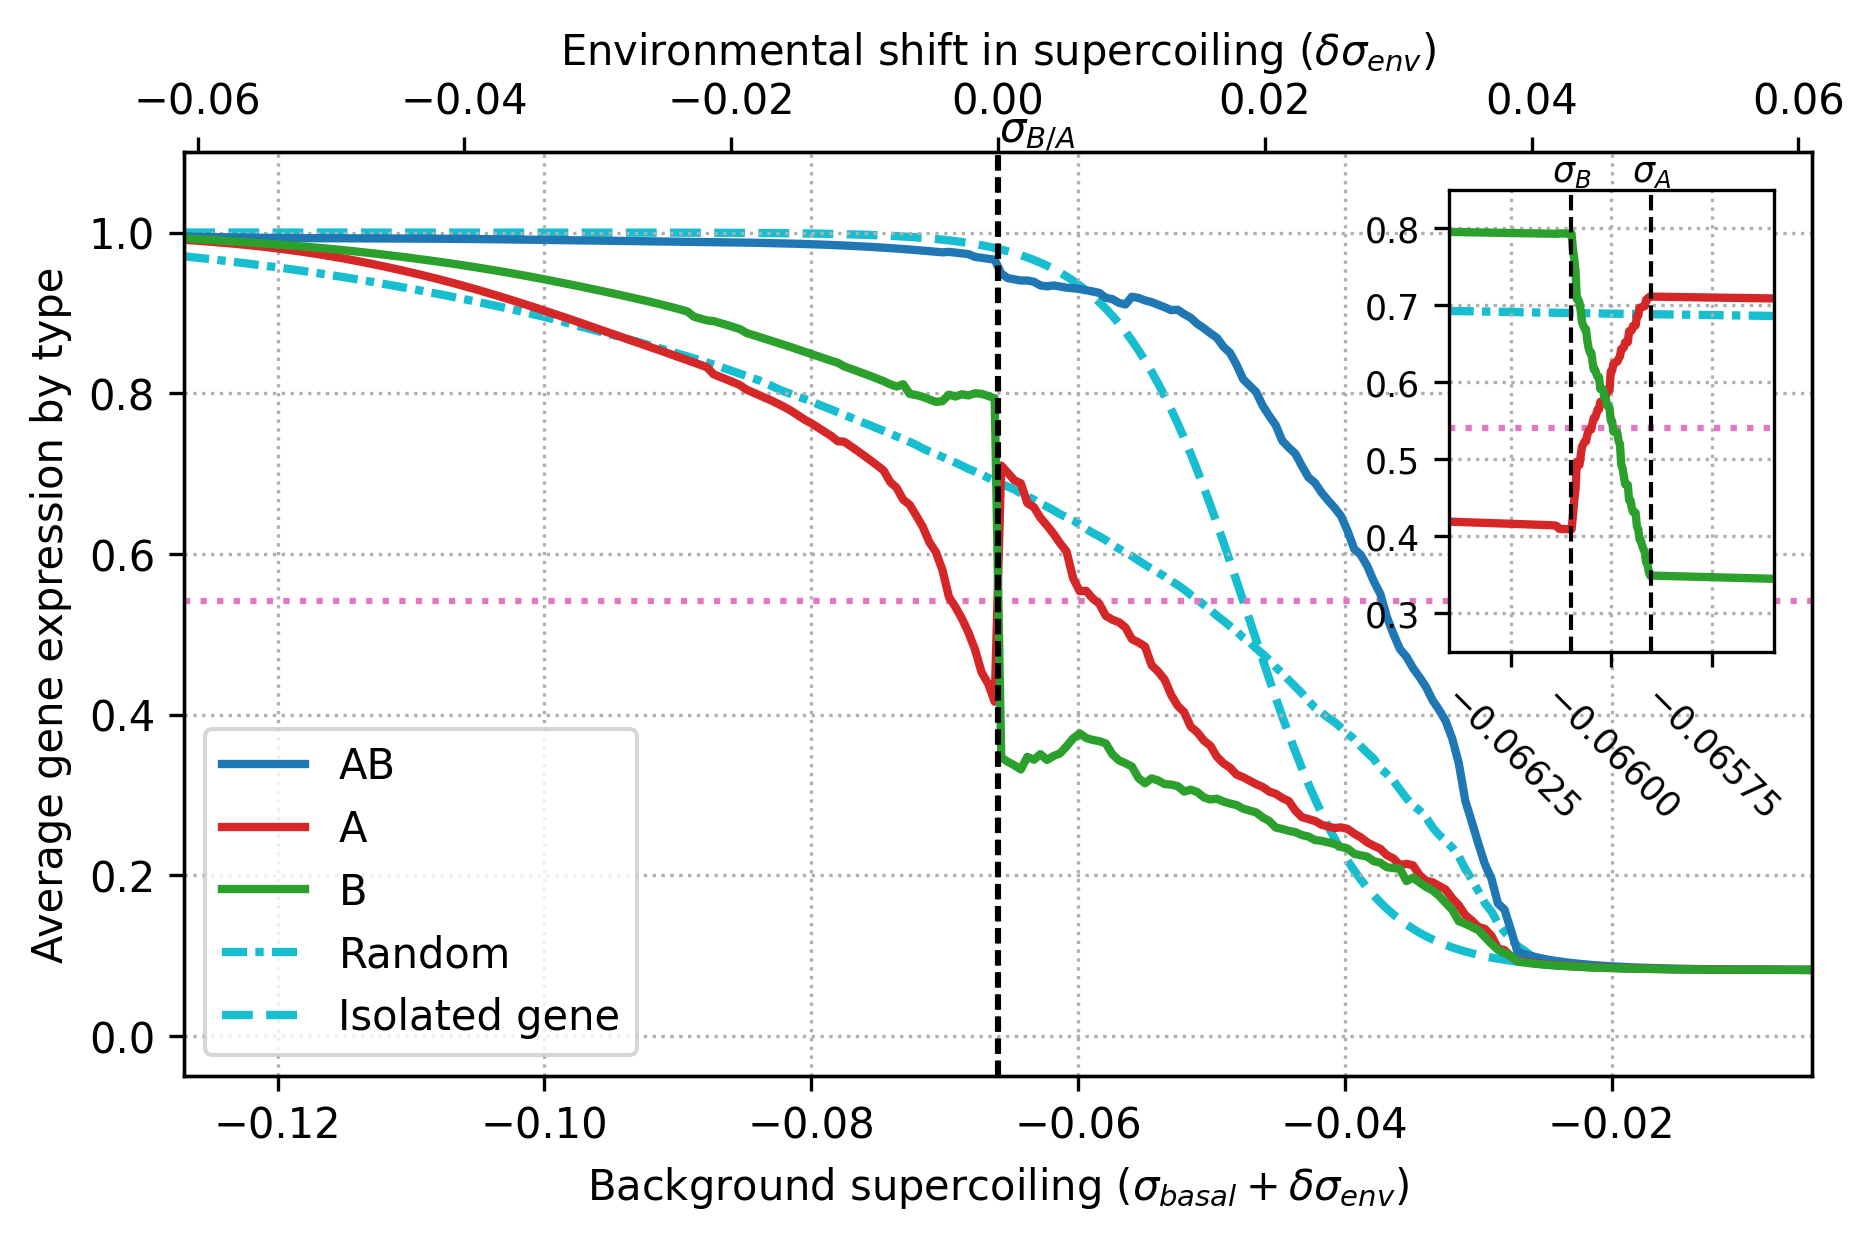

In [27]:
# Sigma_A = sigma_B = 10^-4
plot_activity_sigma_per_type(exp_paths[2], exp_params[2], insert_inset=True,
                             plot_name='activity_sigmas_avg.pdf')

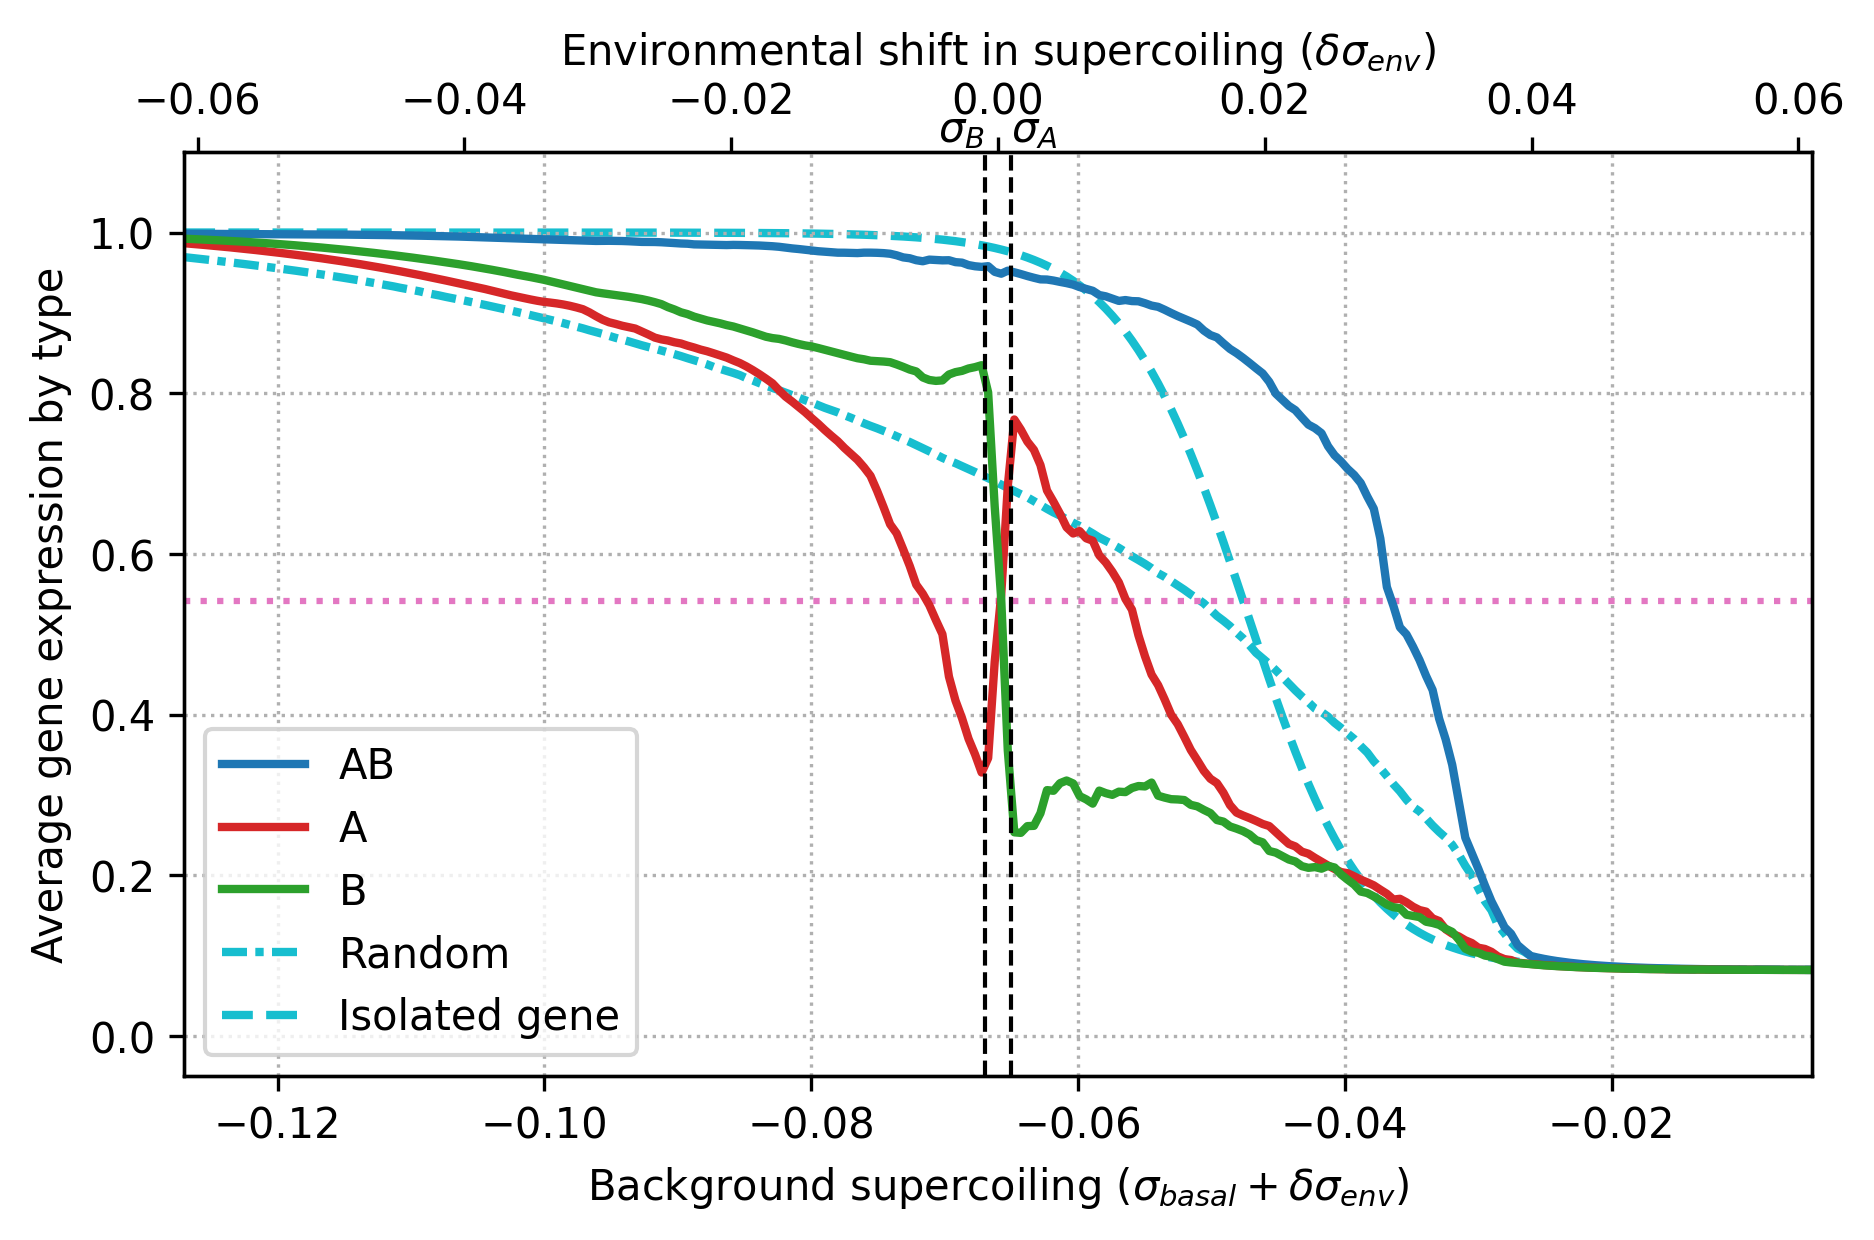

In [28]:
# Sigma_A = sigma_B = 10^-3
plot_activity_sigma_per_type(exp_paths[1], exp_params[1],
                             plot_name='activity_sigmas_avg.pdf')